In [90]:
import pandas as pd
import numpy as np
np.random.seed(2019)

import html
import random
random.seed(2019)

from IPython.core.display import display, HTML
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.utils import shuffle

import os
os.environ['PYTHONHASHSEED'] = str(2019)

from nltk.corpus import words
import torch
torch.manual_seed(2019)
torch.cuda.manual_seed_all(2019)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


# OPTIONAL: if you want to have more information on what's happening under the hood, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

from operator import add

import re
import string

from nltk import sent_tokenize

# from pytorch_transformers import BertTokenizer, BertModel, BertForMaskedLM
from numpy import genfromtxt
from tqdm import tqdm_notebook, trange
from transformers import *
from sklearn.model_selection import train_test_split
import operator



tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

## Basic functions

In [91]:
def read_data(path):

    corpora = []
    for filename in os.listdir(path):

        df_temp = pd.read_csv(path+filename, encoding='iso-8859-1')

        corpora.append(df_temp.text.tolist())

    class_one_len = len(corpora[0])
    class_two_len = len(corpora[1])

    return corpora, class_one_len, class_two_len


## split a document into sentences
def sentences_segmentation(corpora,tokenizer,min_token=0):
    segmented_documents = []
    iterator = tqdm_notebook(corpora, desc="Iteration")
    for idx,document in enumerate(iterator):
    # for i in tqdm(range(len(corpora))):

        segmented_document = []
        seg_document = sent_tokenize(document)

        ## remove sentences that are too short, the tokenized sentences should larger than min_token, otherwise are dropped
        for sentence in seg_document:
            tokenized_sentence = tokenizer.tokenize(sentence)
            if len(tokenized_sentence)>min_token:
                temp_sentence = tokenizer.convert_tokens_to_string(tokenized_sentence)
                ## if a whole sentence consists of punctations, it will be dropped
                if not all([j.isdigit() or j in string.punctuation for j in temp_sentence]):
                    segmented_document.append(temp_sentence)
            
        segmented_documents.append(segmented_document)
    
    return segmented_documents

# Prevent special characters like & and < to cause the browser to display something other than what you intended.
def html_escape(text):
    return html.escape(text)

## Import text data and split them into sentences

In [92]:
paths = ['longer_moviereview']


corpora, class_one_len, class_two_len = read_data('raw_corpora/'+paths[0]+'/')

all_corpus = corpora[0]+corpora[1]

segmented_documents = sentences_segmentation(all_corpus,tokenizer)

C:\Users\jh\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Iteration:   0%|          | 0/2000 [00:00<?, ?it/s]

In [93]:
print('num of document in class one: ',class_one_len)
print('num of document in class two: ',class_two_len)

## lenghts of documents
lengths = []
for doc in segmented_documents:
    lengths.append(len(doc))

print('The length of longest document', np.max(lengths))
print('Avg length of document', np.mean(lengths))

num of document in class one:  1000
num of document in class two:  1000
The length of longest document 118
Avg length of document 33.9665


## Visualise the document lengths distributions

Text(0, 0.5, 'num of documents')

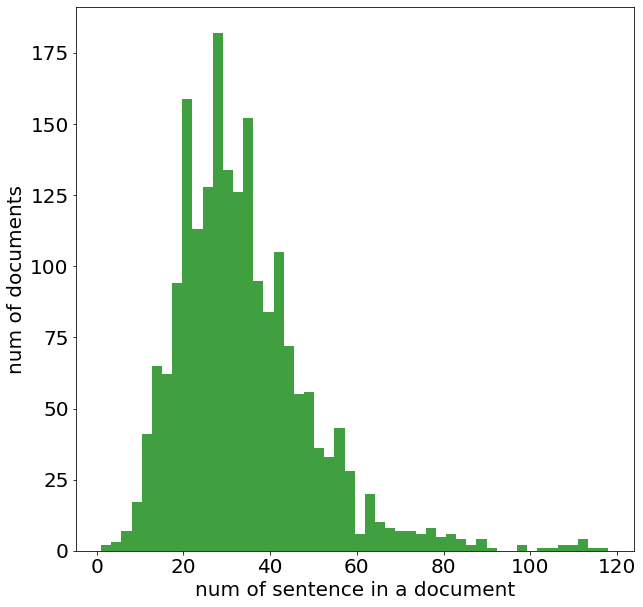

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(10,10))
n, bins,patchs = plt.hist(lengths, 50, facecolor='g', alpha=0.75)
plt.xlabel('num of sentence in a document')
plt.ylabel('num of documents')

## Print one splited document

In [95]:
segmented_documents[0]

[' plot : two teen couples go to a church party , drink and then drive .',
 'they get into an accident .',
 'one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares .',
 "what's the deal ?",
 'watch the movie and " sorta " find out .',
 'critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package .',
 "which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn't snag this one correctly .",
 'they seem to have taken this pretty neat concept , but executed it terribly .',
 'so what are the problems with the movie ?',
 "well , its main problem is that it's simply too jumbled .",
 'it starts off " normal " but then downshifts into this " fantasy " world in which you , as an

## Visualise informative sentences

In [110]:
seed = 1989
epoch = 29
training_size =50
doc_idx=0
## hyperparameters of HBM: the maximum lenghth of document HBM can take
max_len = 118
cut_off = 0.5

attention_scores = torch.load('./attentions/%s/epoch%s_seed%s_size%s.pt'%(paths[0],epoch,seed,training_size))
LABEL_emb = np.array([0]*class_one_len+[1]*class_two_len)

In [111]:
attention_scores.shape

torch.Size([1800, 1, 118, 118])

In [112]:
## using the same randomisation as in the training HBM
index_shuffle = shuffle([i for i in range(len(all_corpus))], random_state=seed)

## get index of the testing documents
test_shuffle = index_shuffle[200:]

test_segmented_documents = list(np.array(segmented_documents)[test_shuffle])
test_label = LABEL_emb[test_shuffle]
text_len = min(max_len,len(test_segmented_documents[doc_idx]))

C:\Users\jh\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [113]:
doc_attention_score = torch.tensor(attention_scores[doc_idx])

accum_attention_score = doc_attention_score[0].sum(axis=0)

C:\Users\jh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [114]:
weights = {}
max_weight = max(accum_attention_score)
for idx,attention in enumerate(accum_attention_score[:text_len]):
    weights[idx]=float(attention)

In [115]:
max_alpha = max(weights.values()) 
highlighted_text = []
# length = min(len(weights),len(segmented_documents[doc_idx]))

for idx in range(text_len):
    weight = weights[idx]
    text = test_segmented_documents[doc_idx][idx]
    if weight/max_weight>cut_off:
        highlighted_text.append('<span style="background-color:rgba(135,206,290,' + str(weight/max_alpha) + ');">' + html_escape(text) + '</span>')
    else:
        highlighted_text.append(text)
highlighted_text = ' '.join(highlighted_text)
#highlighted_text

In [116]:
print(test_label[doc_idx])
display(HTML(highlighted_text))

1
